# Reeb Graph Matching
#### Implementing 'Topology Matching for Fully Automatic Similarity Estimation of 3D Shapes'
#### http://graphics.stanford.edu/courses/cs468-08-fall/pdf/Hilaga01.pdf
#### (Hilaga et al., 2001)

In [47]:
import numpy as np
import os
from os.path import isfile, join
from os import listdir
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import csd_functions
import scipy
import networkx as nx
sns.set()


Load tree data

In [2]:
prefix = 'input_strength032320'
node_points, node_connectivity, node_color = csd_functions.load_tree(prefix)

Plot unprocessed critical point data

In [7]:
%matplotlib qt
fig = plt.figure(figsize = (8,6))
ax = plt.axes(projection='3d')

num_pairs = node_connectivity.shape[0]
for pair in range(num_pairs):
    pairID = node_connectivity[pair]
    pairID
    xdata, ydata, zdata = node_points[pairID, 0], node_points[pairID, 1], node_points[pairID, 2]

    ax.plot(xdata,ydata,zdata, 'k', linewidth=0.2)

num_points = node_points.shape[0]
ax.scatter(node_points[:, 0], node_points[:, 1], node_points[:, 2], 'b')

plt.show()

Resample tree to fit inside range

In [114]:
min_elevation, max_elevation = min(node_points[:,2]), max(node_points[:,2])
node_differences = np.sort(np.diff(np.sort(node_points[:,2]))) #Sorted list of height difference bettwen all nodes

#Number of level sets for reeb graph
num_intervals = 30
interval_width = (max_elevation-min_elevation)/(num_intervals-1)
low, high = min_elevation - (interval_width/2), max_elevation + (interval_width/2)

#Centers the minimum and maximum nodes at the min and max intervals
interval_bound = [[low + interval_width*pos, low + interval_width*(pos+1)] for pos in range(num_intervals)]
interval_points = np.array([low + interval_width*pos for pos in range(num_intervals+1)])



In [123]:
# print(interval_points < -0.5)
# print(np.sum(interval_points < -0.5))
# print(interval_points)
list([5])

[5]

In [ ]:
# adds or removes nodes based on interval
def edge_edit(B, start_node, end_node, interval_points):

    #Height of current node
    start_val = B.nodes[start_node]['Position'][2]
    end_val = B.nodes[end_node]['Position'][2]

    #Upper bound index for the start and ending node heights
    start_bound_idx, end_bound_idx = np.sum(interval_points < start_val), np.sum(interval_points < end_val)

    #Update node positions to center of interval
    B.nodes[start_node]['Position'][2] == np.mean(interval_points[start_bound_idx-1:start_bound_idx])
    B.nodes[end_node]['Position'][2] == np.mean(interval_points[end_bound_idx-1:end_bound_idx])

    #Represents how many intervals the edge spans
    bound_diff = abs(start_bound_idx - end_bound_idx)

    #Edge spans exactly 1 bound as desired, update node position and return
    if bound_diff == 1:

        return

    #Connected nodes in same interval, merge together and update attribute dictionary
    elif bound_diff == 0:
        #End node gets deleted
        B = nx.contracted_edge(B,[start_node,end_node])
        B.nodes[start_node]['Merged'].append(end_node)
        return

    #Edge spans more than one interval, subdivide
    elif bound_diff > 1:


        return


    




#Recursive function that goes through all edges 
def graph_search(A, start, interval_points):
    if A.nodes[start]['Visited'] == 1:
        return
    else:
        neighbors = list(A.neighbors(start))

        #Insert or remove nodes based on interval position
        for neighbor_id in neighbors:
            edge_edit(A, start, neighbor_id, interval_points)


        A.nodes[start]['Visited'] = 1
        



In [112]:
G = nx.Graph()
G.add_edges_from(node_connectivity)

node_attributes = {node_id : {'Position' : node_points[node_id,:], 'Visted' : 0, 'Merged':[],'Inserted':[]} for node_id in list(G.nodes)}
nx.set_node_attributes(G,node_attributes)

edge_list = list(G.edges)


-0.862648

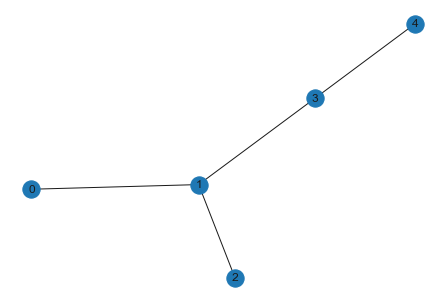

In [57]:
plt.figure()
A = nx.Graph()
A.add_edges_from(np.array([[0,1],[1,2],[1,3], [3,4]]))
nx.draw(A,with_labels = True)

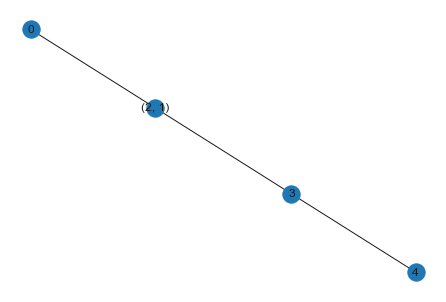

In [128]:
B = A.copy()
edge_test = [2,1]
B = nx.contracted_edge(B,edge_test)
mapping = {edge_test[0]: tuple(edge_test)}
nx.relabel_nodes(B, mapping=mapping, copy=False)
nx.draw(B,with_labels=True)

In [126]:
B = A.copy()
def test_change(A):
    A.add_edge(4,5)
    return

print(B.edges)
test_change(B)
print(B.edges)
print(list(B.neighbors(1)))

[(0, 1), (1, 2), (1, 3), (3, 4)]
[(0, 1), (1, 2), (1, 3), (3, 4), (4, 5)]
[0, 2, 3]
